In [1]:
import pandas as pd
df= pd.read_csv("ISOT-172-16.csv")
ips=set(df.src.to_list()+df.dst.to_list())
# len(ips)

In [2]:
import pickle
with open('flow1.pickle', 'rb') as handle:
    flow = pickle.load(handle)

In [3]:
malicious={"172.16.2.11","172.16.0.2","172.16.0.11","172.16.0.12","172.16.2.12"}
nonmalicious={"172.16.2.2","172.16.2.3","172.16.2.11","172.16.2.12","172.16.2.13","172.16.2.14","172.16.2.111","172.16.2.112","172.16.2.113","172.16.2.114"}

In [4]:
mx=0
maxkey=None
for k in flow.keys():
#     print(len(flow[k]),end="\r")
    if k[0] in malicious and len(flow[k])>mx:
        mx=len(flow[k])
        maxkey=k
print(maxkey)
mintime=11000000
maxtime=0
for key in flow.keys():
    mintime=min(flow[key][len(flow[key])-1][0]-flow[key][0][0],mintime)
    maxtime=max(flow[key][len(flow[key])-1][0]-flow[key][0][0],maxtime)
print(mintime)
print(maxtime)
len(flow.keys())

('172.16.2.12', '90.14.88.143', 1712, 49645, 6)
0.0
116996.42946696281


128385

In [38]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 50})
def plot(figname,flow,savelabel):
#     const=flow[0][0]
    plt.figure(figsize=(60,30))
    plt.plot(flow,'r')
    plt.ylabel('Size of packet (Bytes)')
    plt.xlabel('Timestamp (1 unit= 3 Seconds)')
    plt.savefig(savelabel)
    plt.show()
    
def flowWindowmerge(flowlist,starttime,stoptime,mergeseconds):
    #returns packets merged within time interwals
    newflow=[]
    sizepack=0
    for packet in flowlist:
        if packet[0]>stoptime:
            break
        if starttime>packet[0]:
            continue
        if packet[0]<starttime+mergeseconds:
            sizepack=sizepack+packet[1]
        else:
            newflow.append(sizepack)
            starttime+=mergeseconds
            sizepack=0
    return newflow

def flowWindow(flowlist,starttime,stoptime):
    #returns all the packet lenght from start time to stop time
    newflow=[]
    sizepack=0
    for packet in flowlist:
        if packet[0]>stoptime:
            break
        if starttime>packet[0]:
            continue
        newflow.append(packet[1])
    return newflow

def reverse(tuple):
    return (tuple[1],tuple[0],tuple[3],tuple[2],tuple[4])
def drawflow(k,savelabel):
    f=sorted(flow[k]+flow[reverse(k)])
    f=flowWindowmerge(f,f[0][0],f[0][0]+120,3)
    plot("mal_172-16-2-12",f,savelabel)

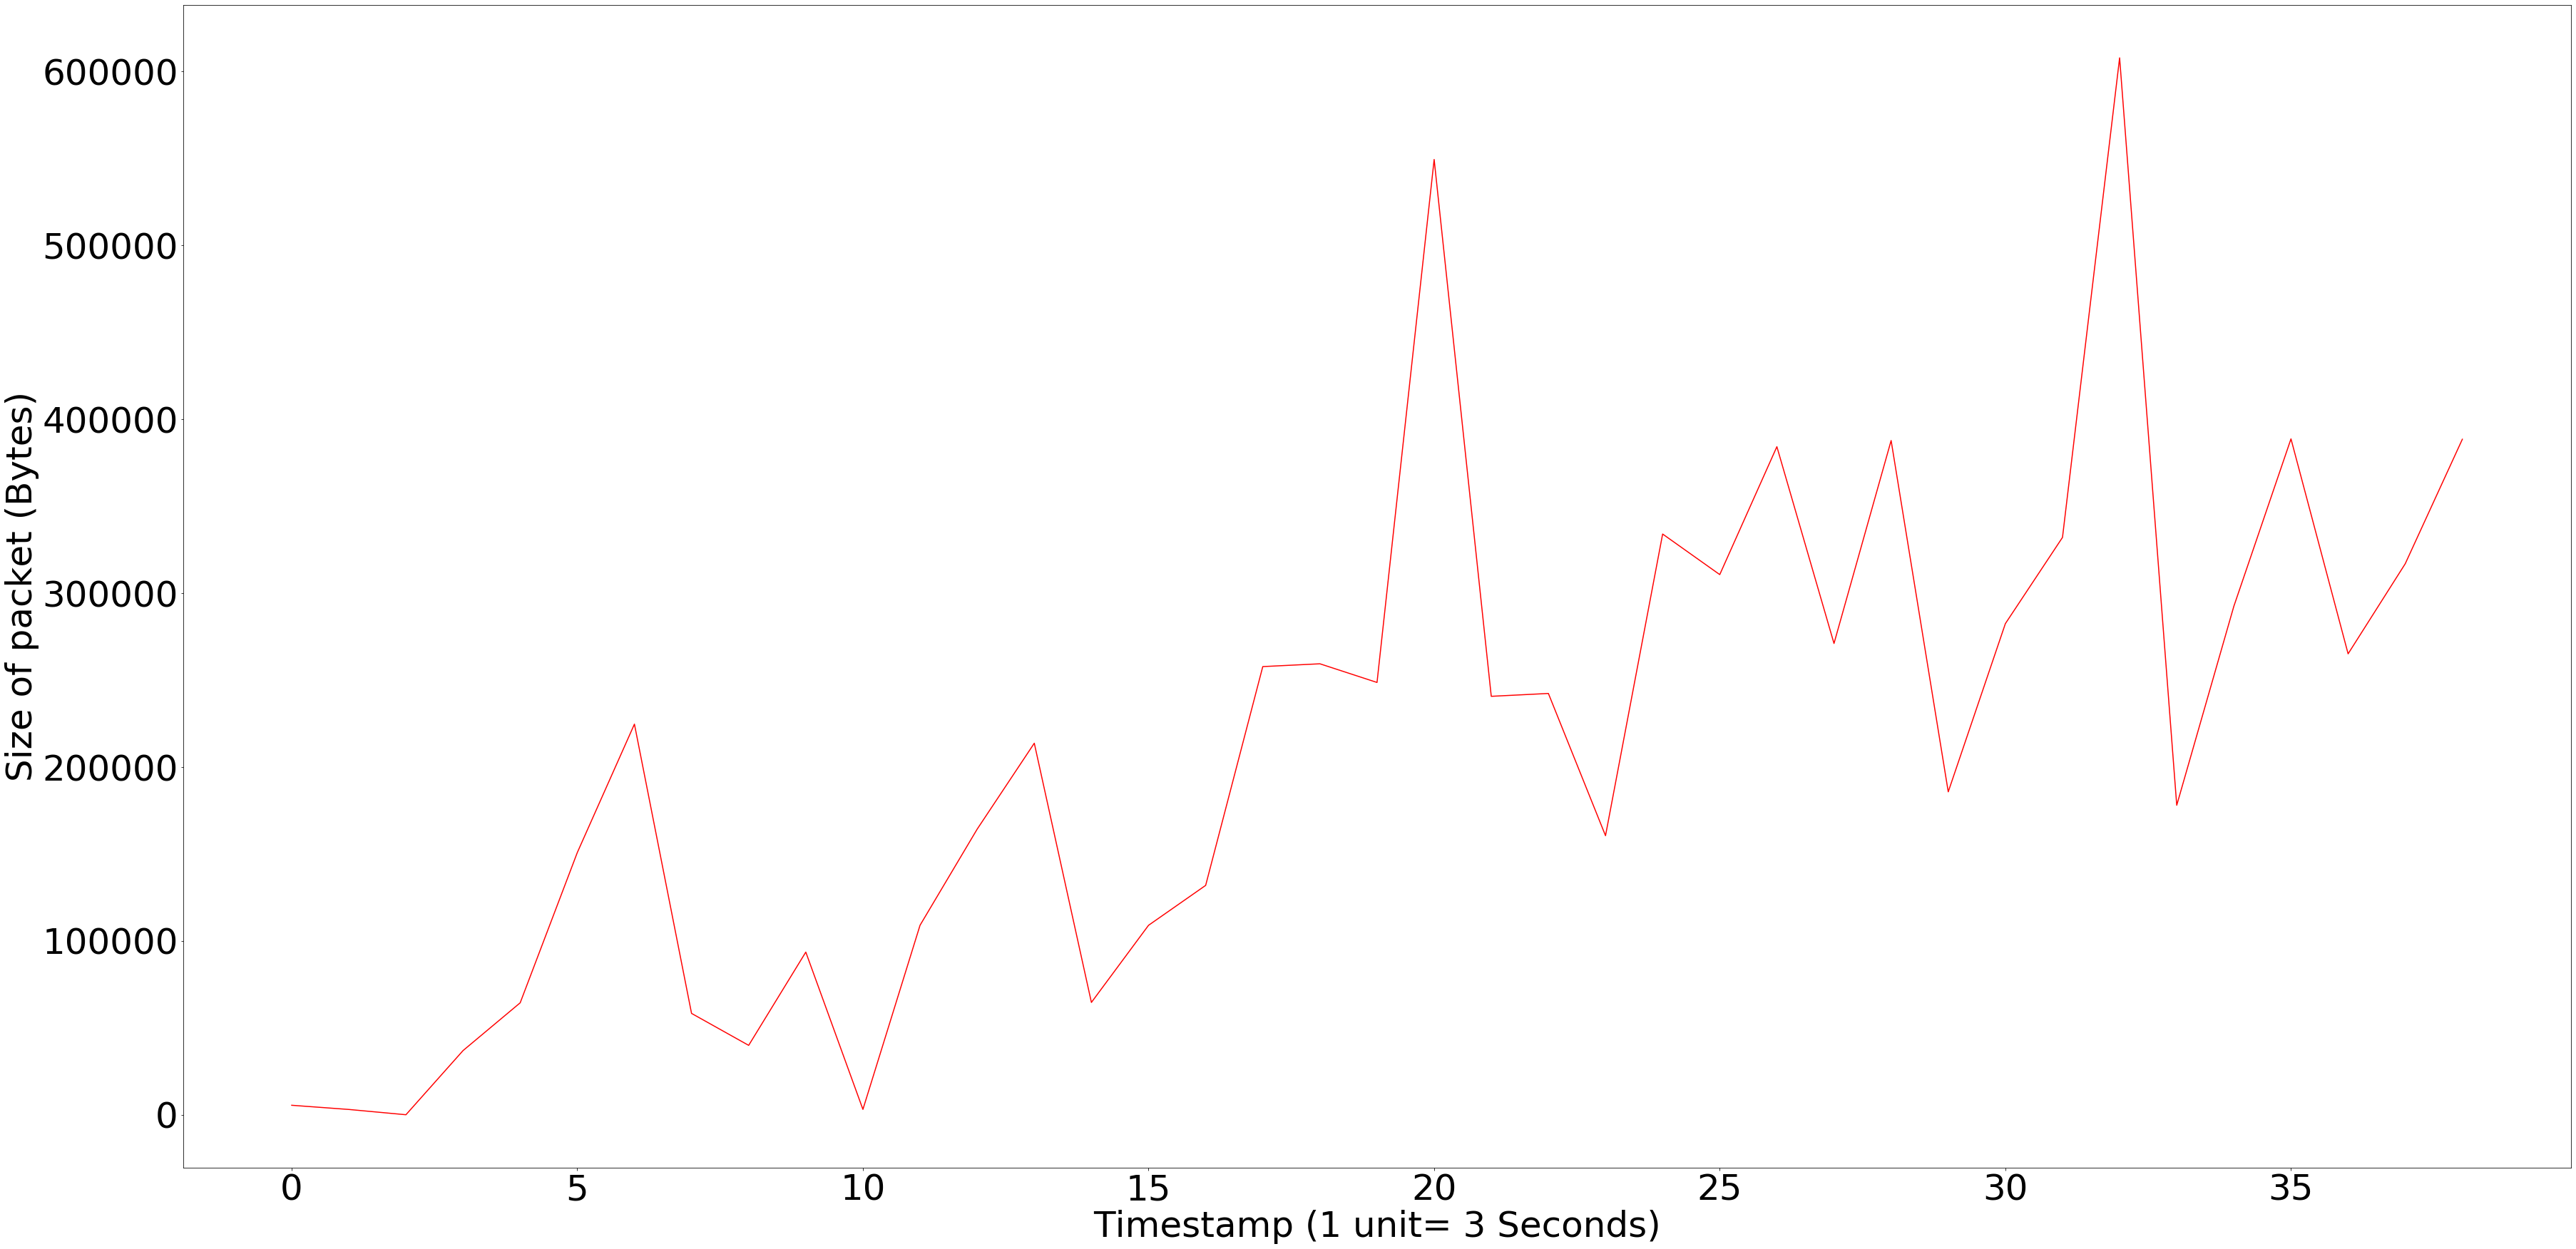

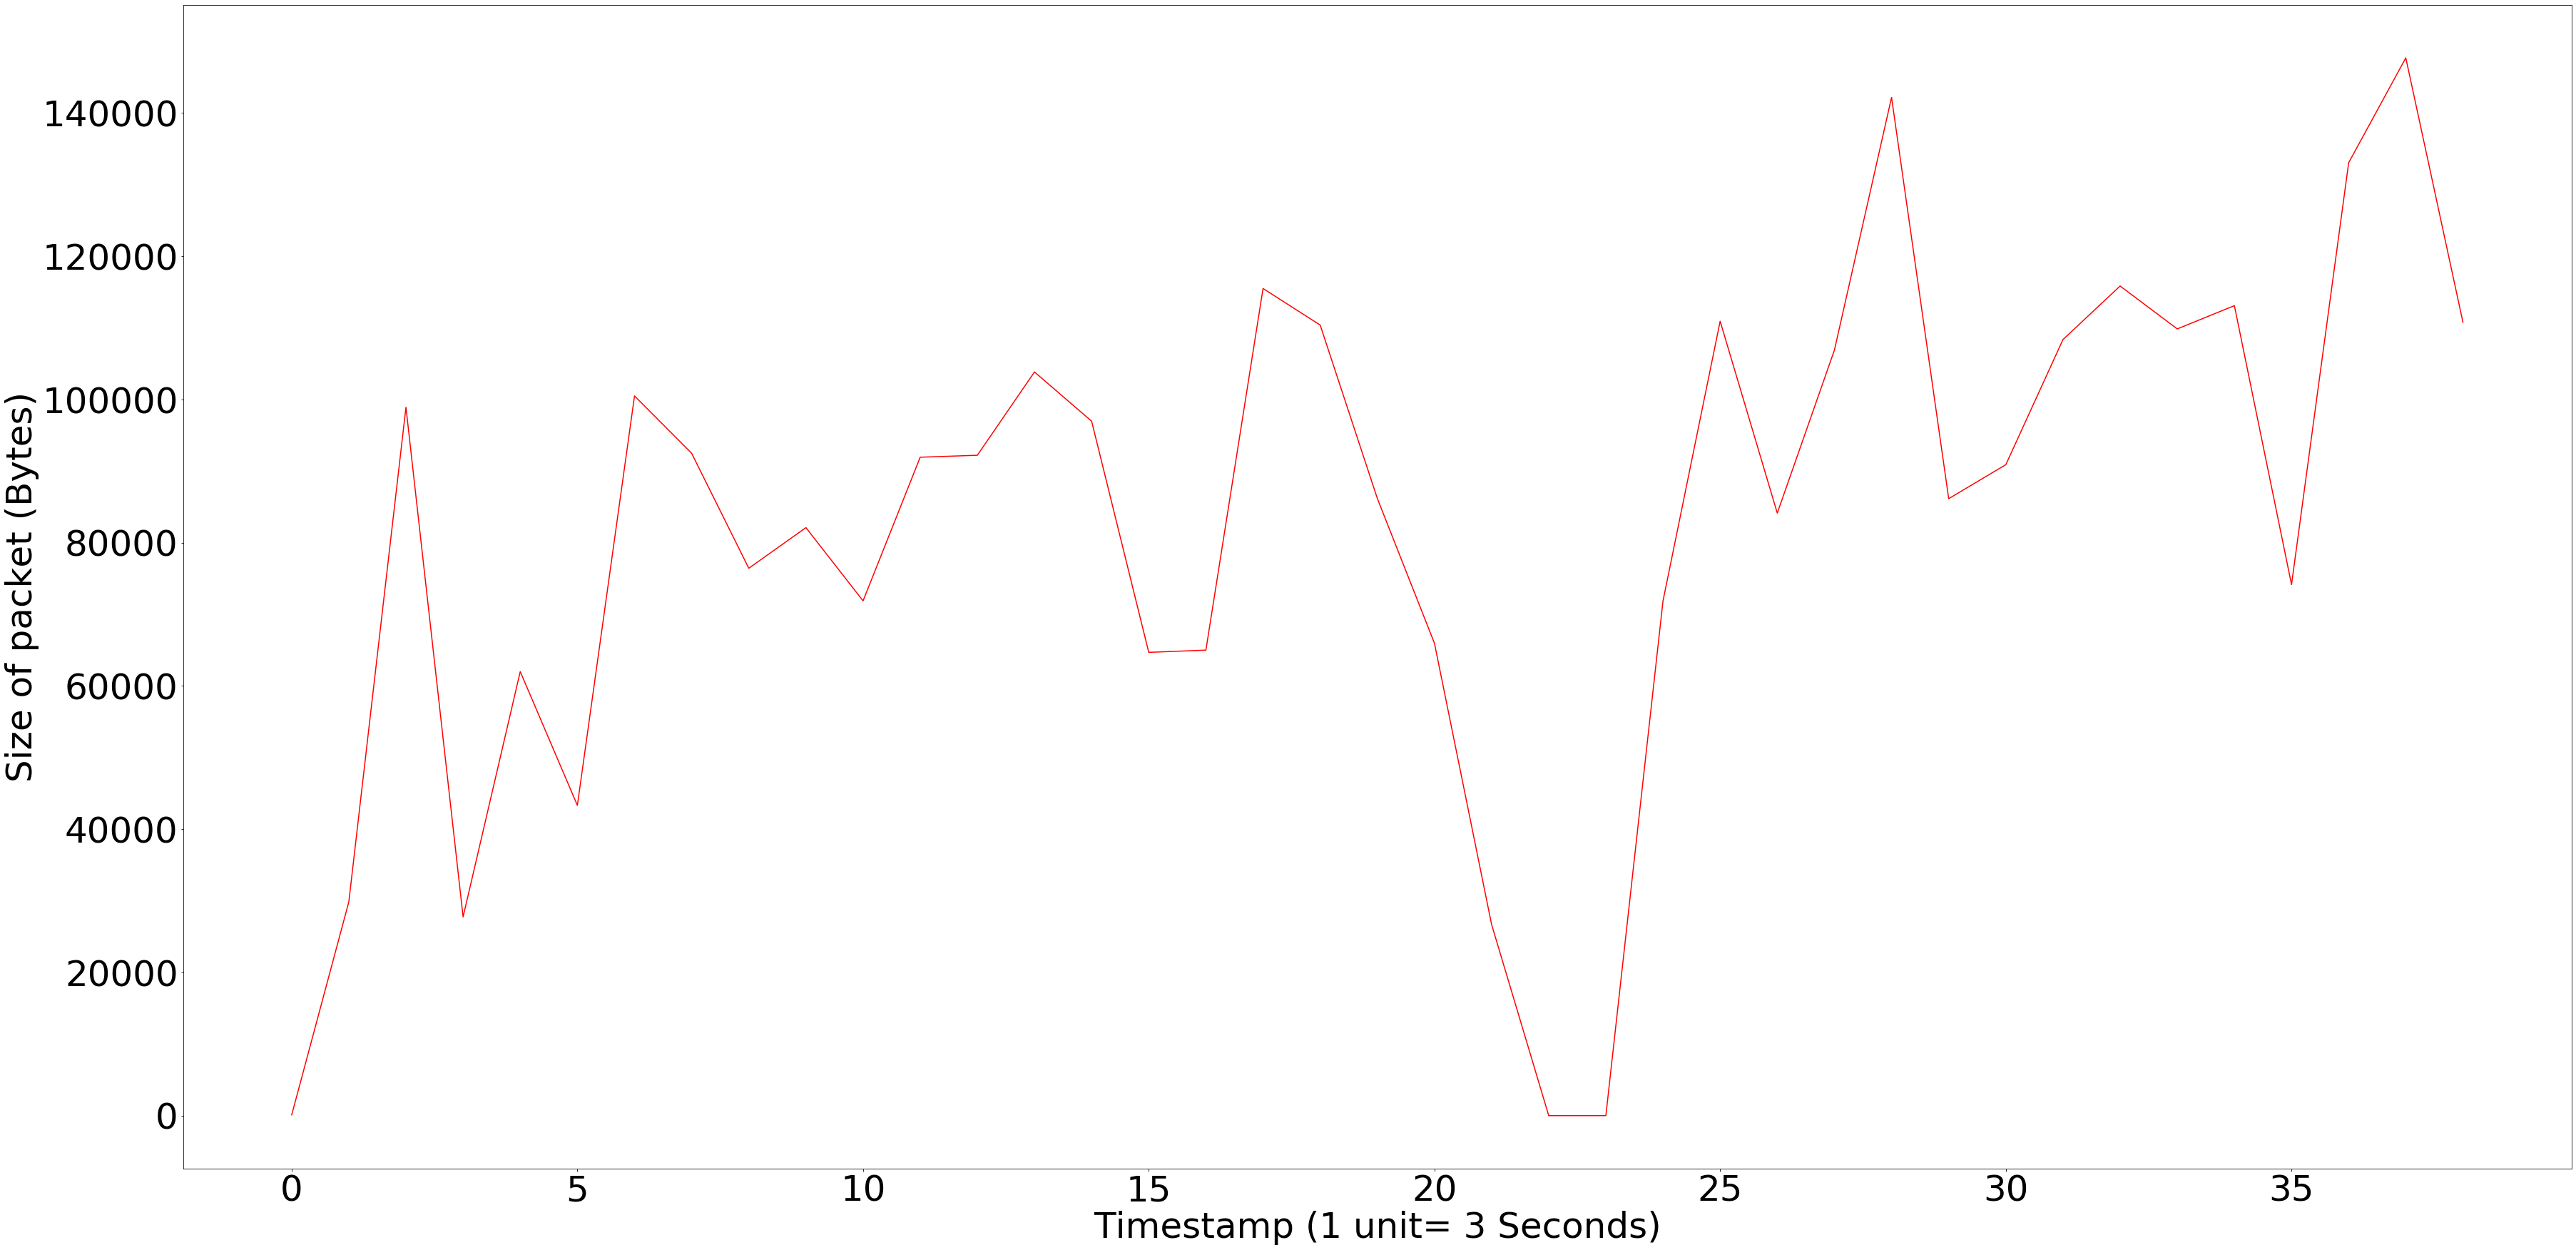

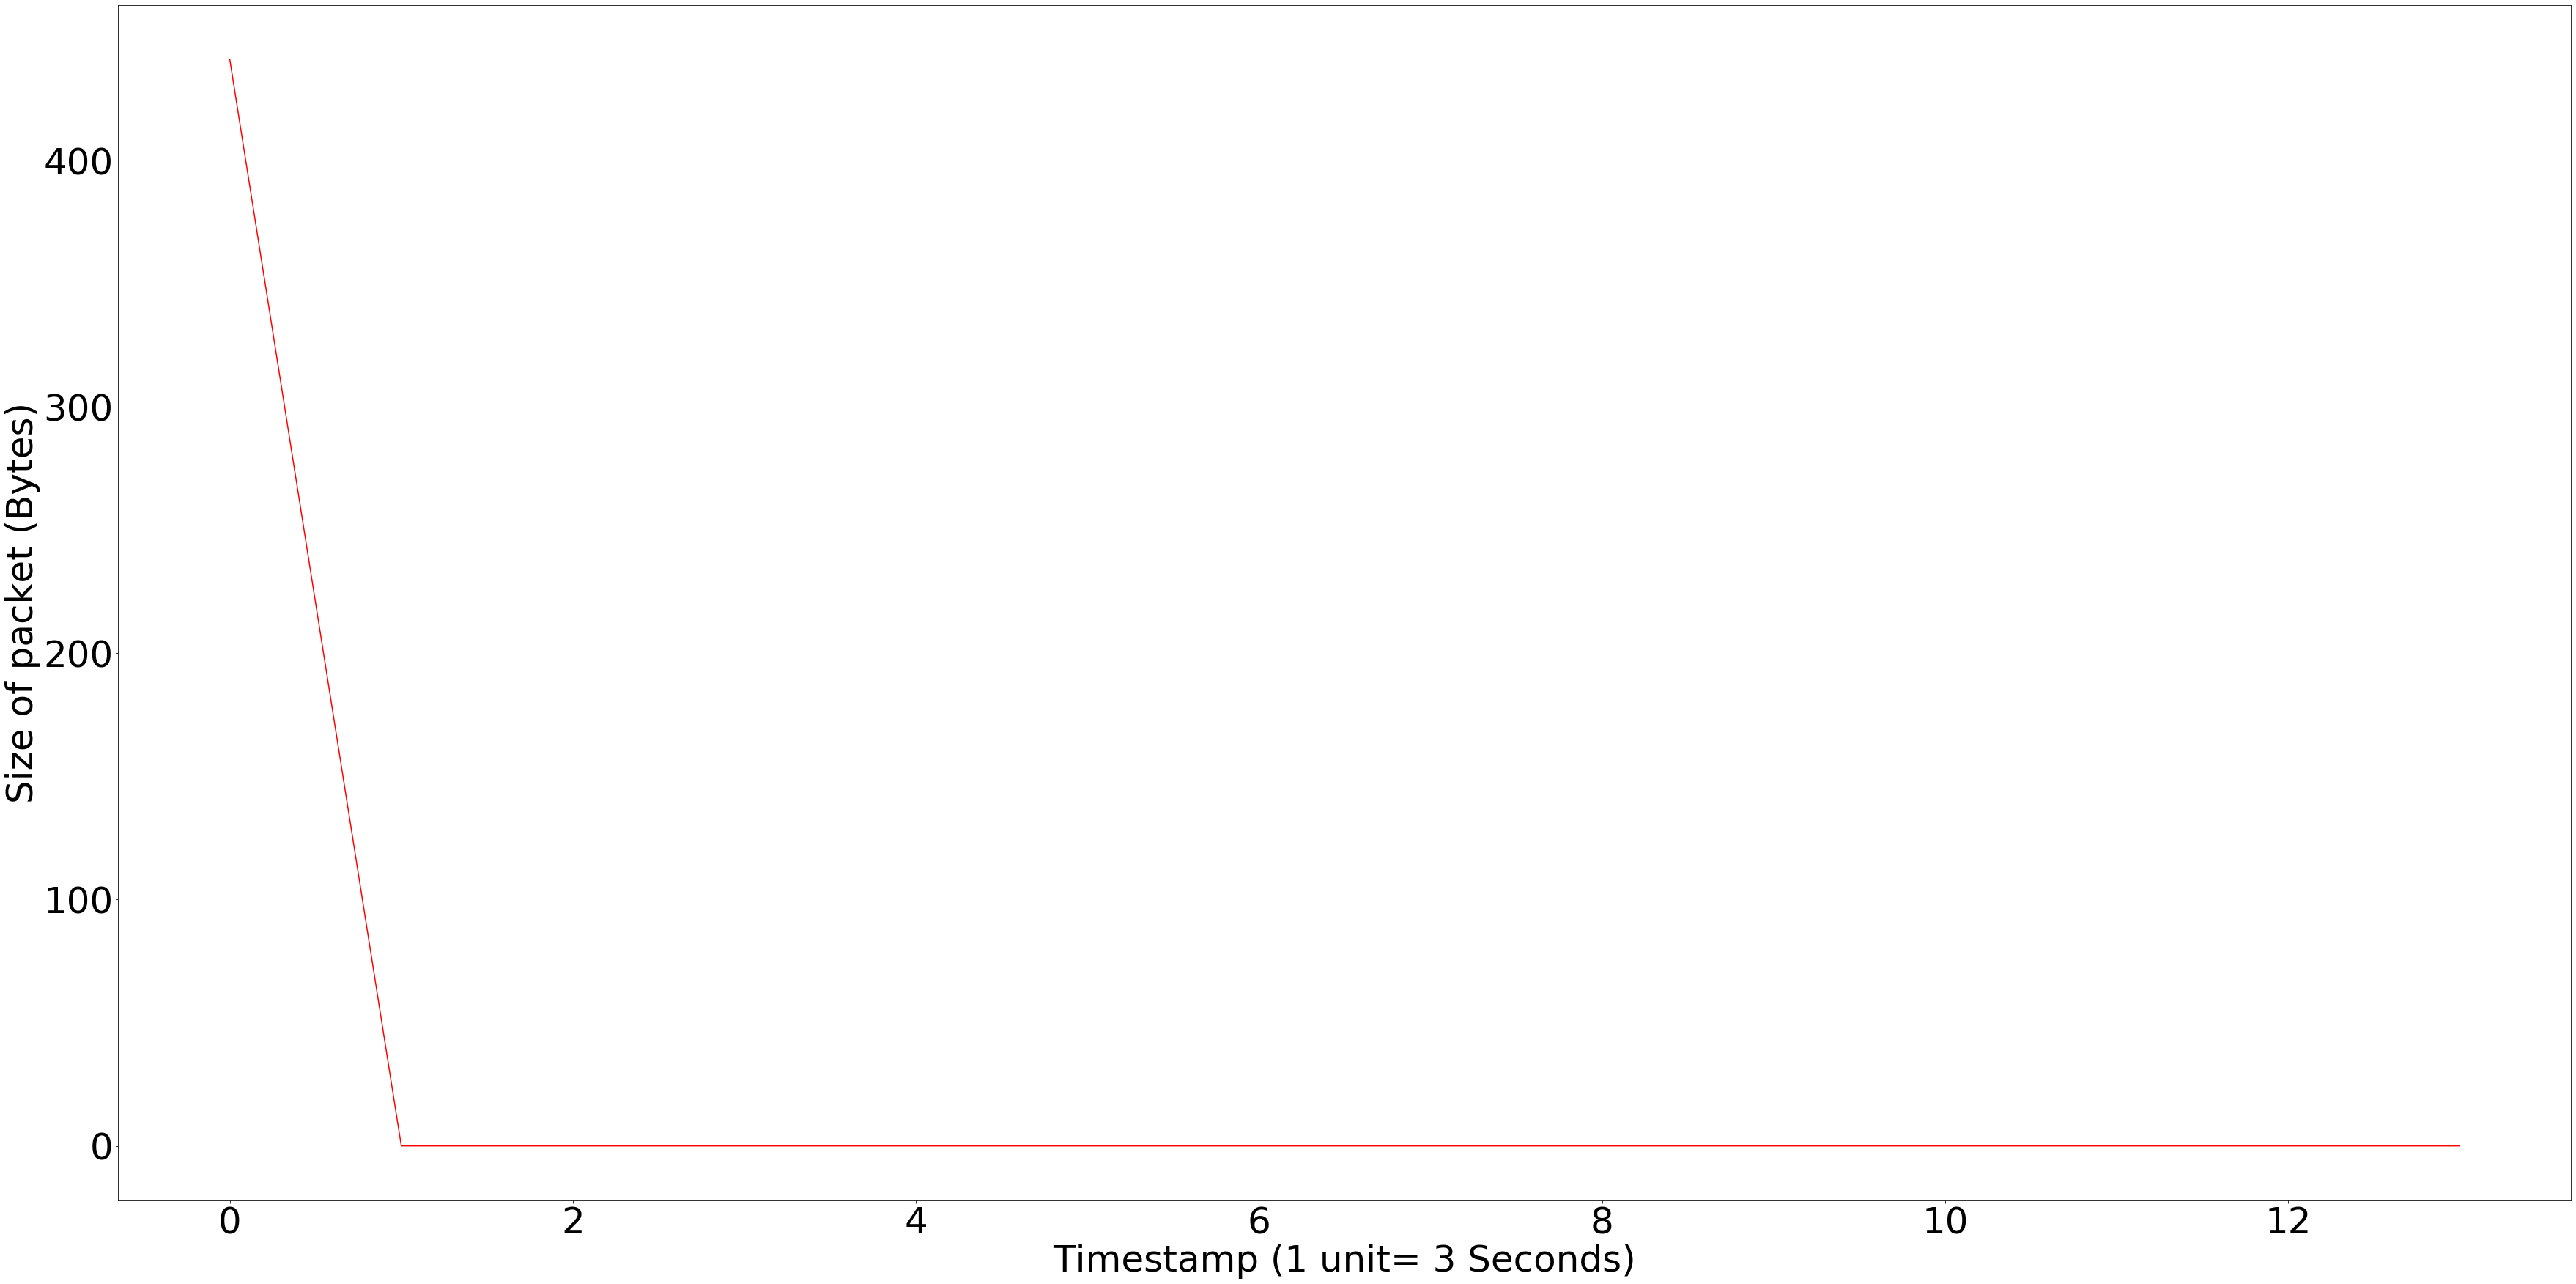

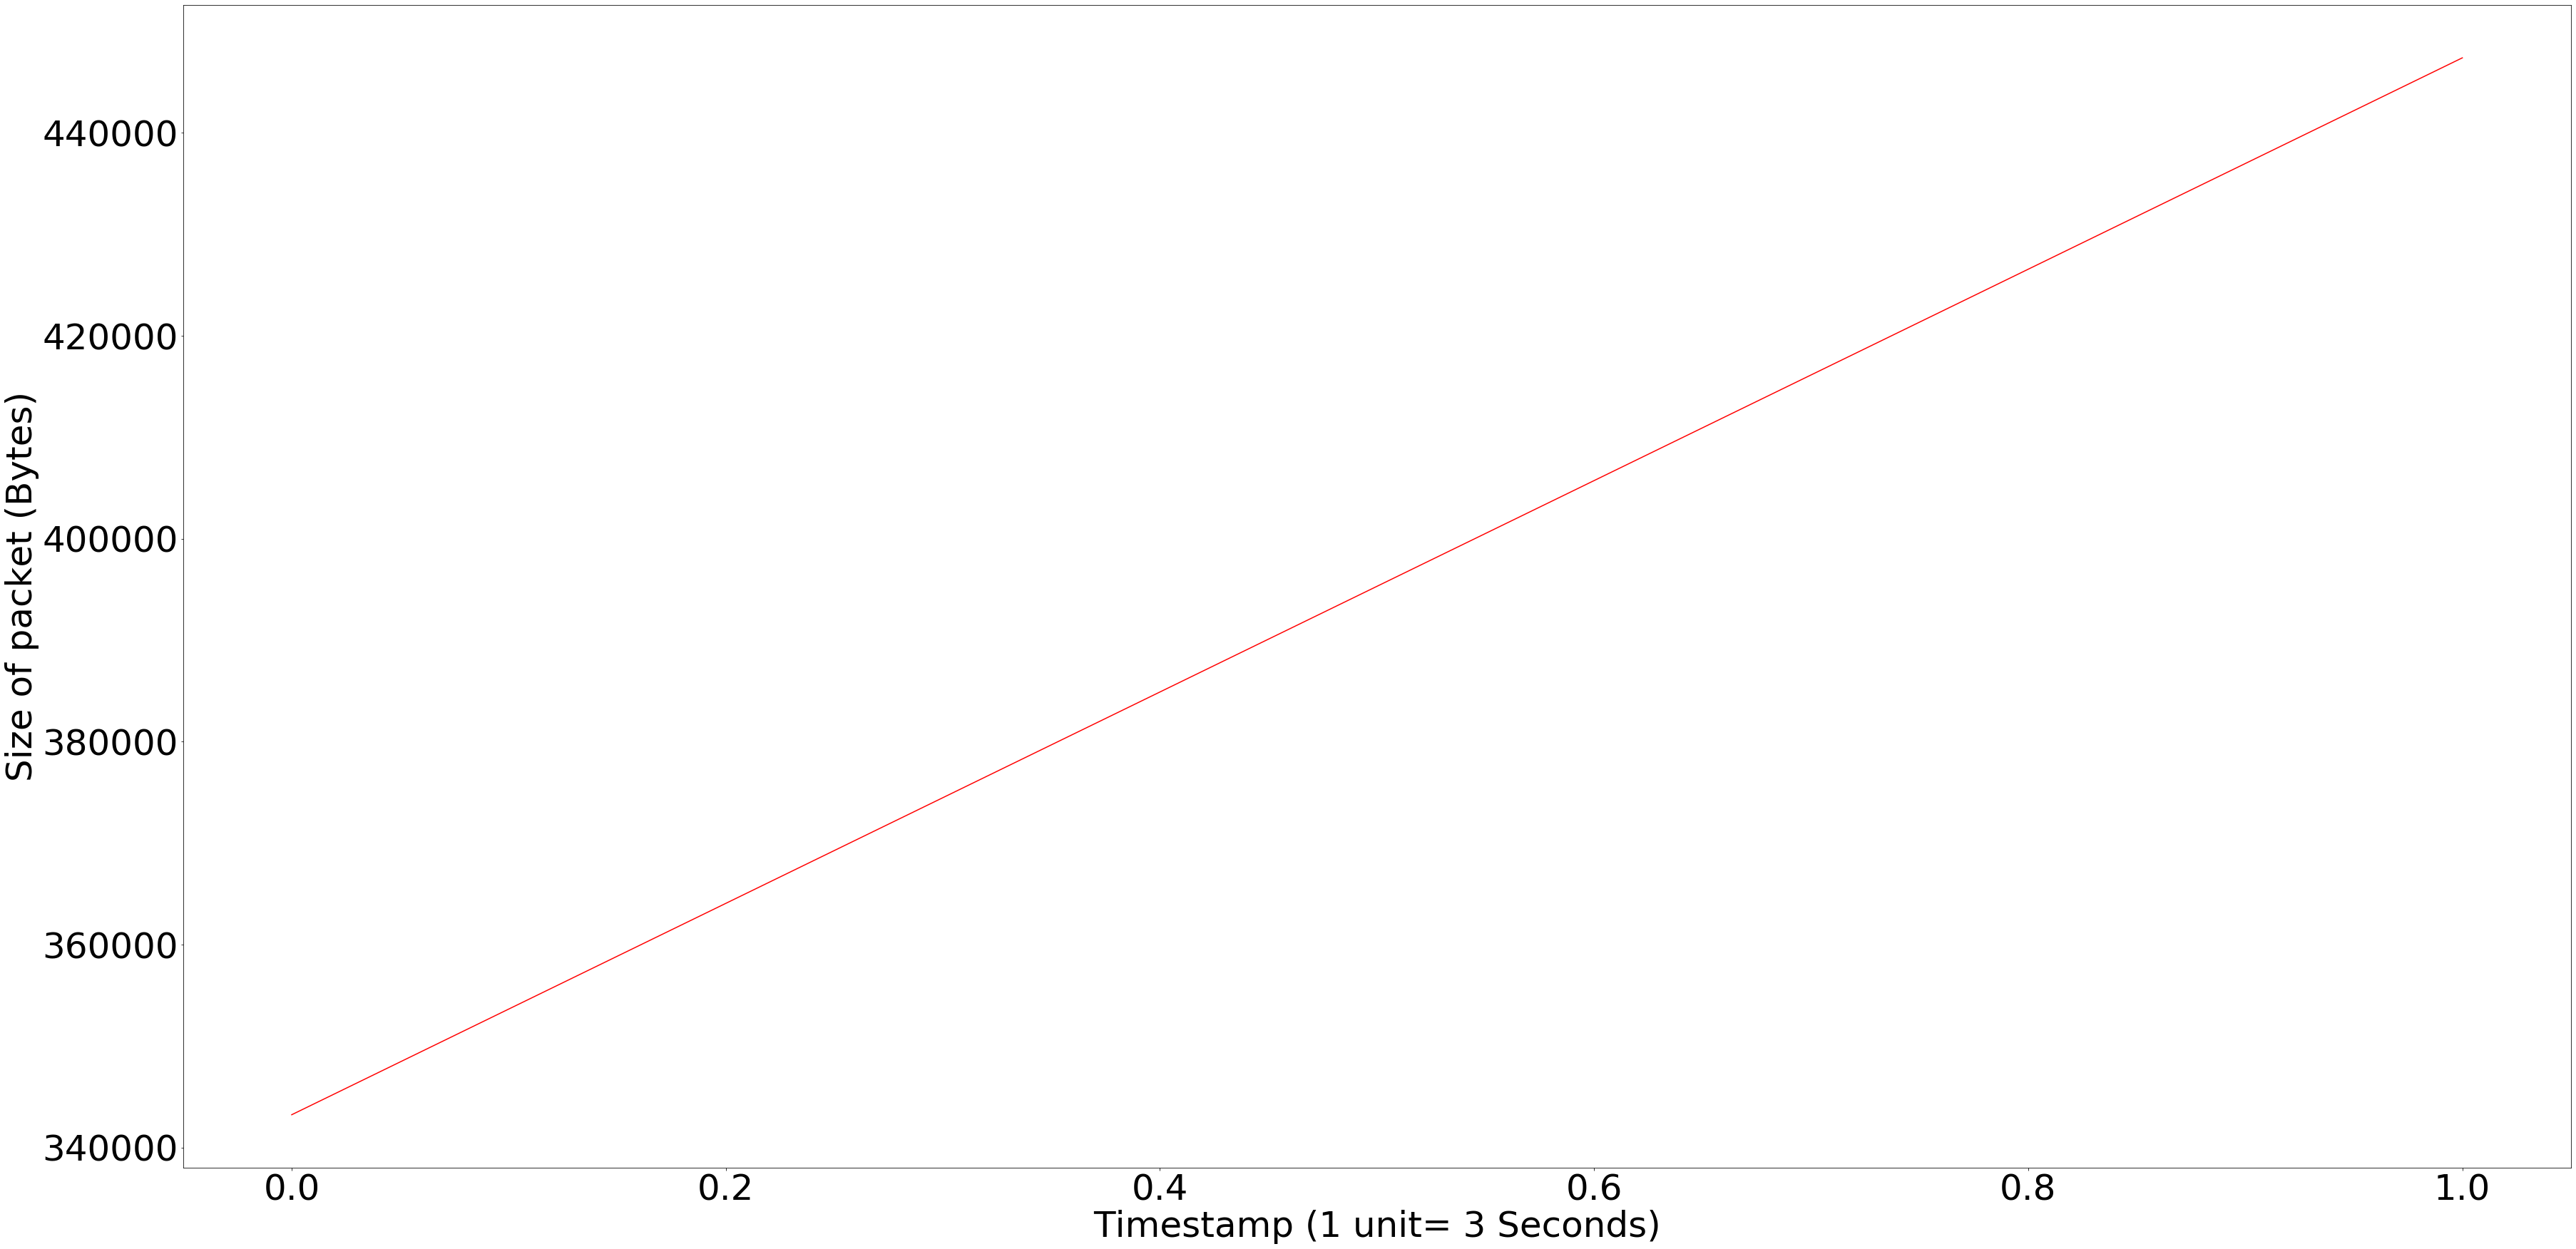

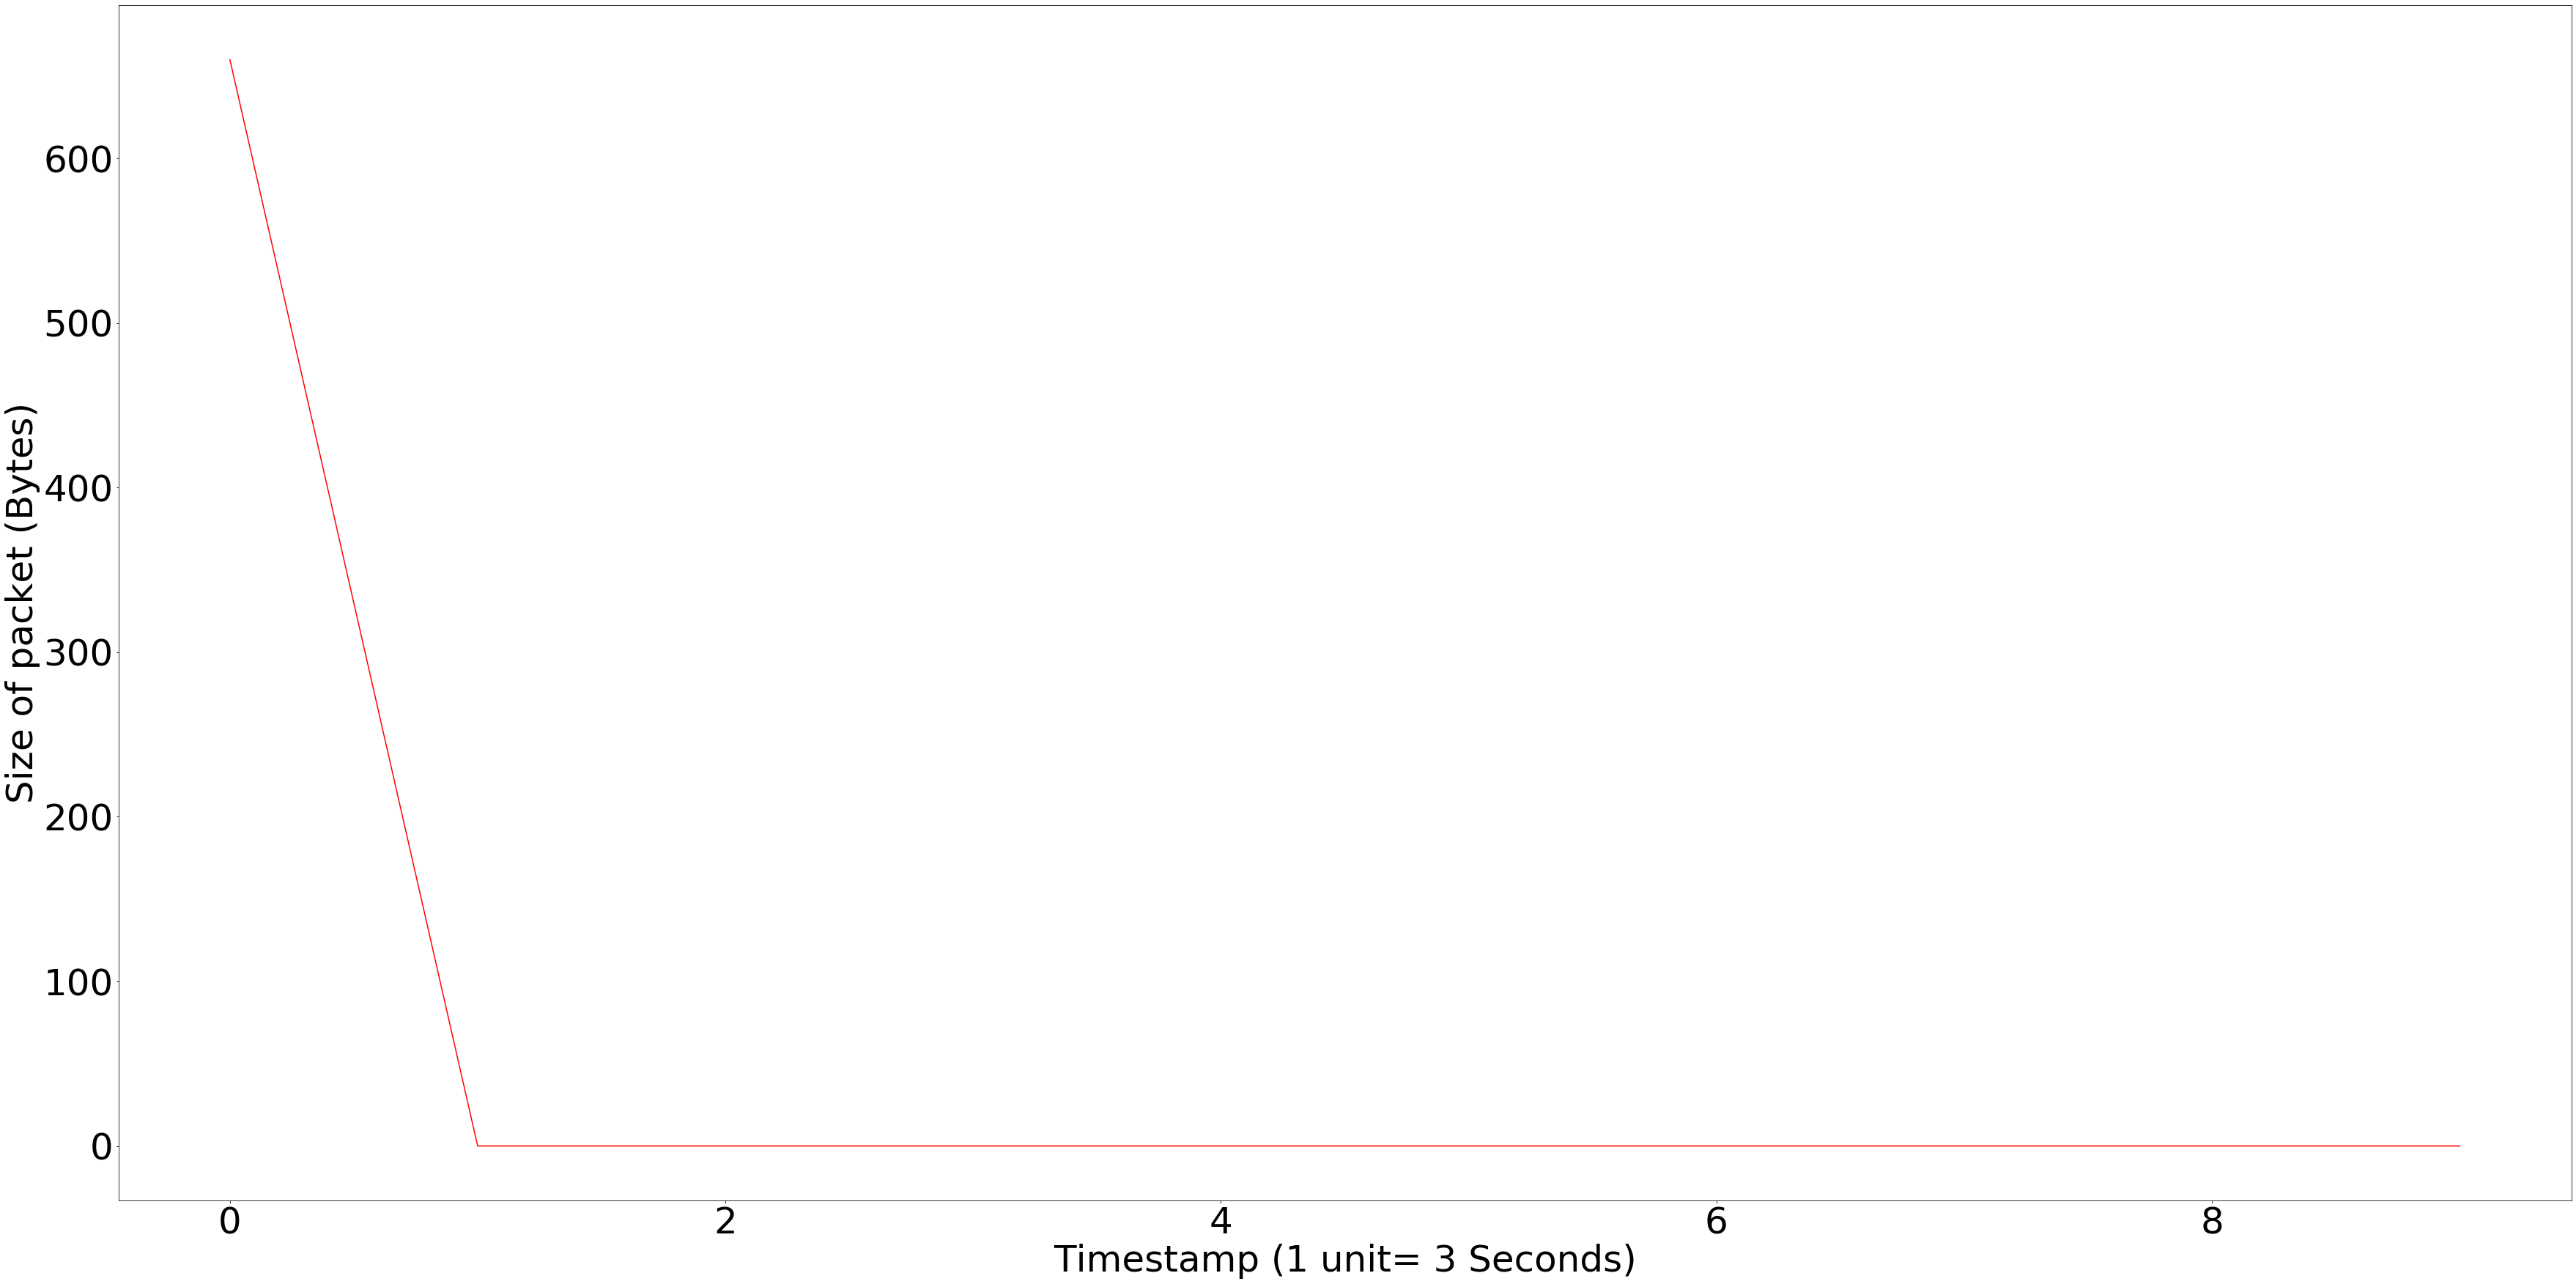

In [39]:
#normal flow
drawflow(('195.50.87.130','172.16.2.2',  80,1097, 6),"malflow")
#malflow
drawflow(('172.16.2.12', '90.14.88.143', 1712, 49645, 6),"nonmaltcpflow")
#udp
drawflow(("172.16.2.11","69.119.180.134",32245,20228,17),"maludpflow")
#malflow
drawflow(("172.16.2.12","209.85.135.91",1244,80,6),"none")
#malflow
drawflow(("172.16.0.11","85.118.41.93",22252,6679,17),"maludpflow")

In [20]:
df.head()

,src,dst,sport,dport,proto,time,len,macsrc,macdst
0,172.16.0.12,198.155.242.22,1035,80,6,1.286403e+09,48,aa:aa:aa:aa:aa:aa,aa:aa:aa:aa:aa:aa
1,172.16.0.12,64.95.58.150,1036,80,6,1.286403e+09,48,aa:aa:aa:aa:aa:aa,aa:aa:aa:aa:aa:aa
2,64.95.58.150,172.16.0.12,80,1036,6,1.286403e+09,48,aa:aa:aa:aa:aa:aa,aa:aa:aa:aa:aa:aa
3,172.16.0.12,64.95.58.150,1036,80,6,1.286403e+09,40,aa:aa:aa:aa:aa:aa,aa:aa:aa:aa:aa:aa
4,172.16.0.12,64.95.58.150,1036,80,6,1.286403e+09,255,aa:aa:aa:aa:aa:aa,aa:aa:aa:aa:aa:aa


In [28]:
def findlabel(ip,mac):
    if ip[0:7]!="172.16.":
        return 0
    if ip in malicious and nonmalicious:
        if mac=="CC:CC:CC:CC:CC:CC" or mac=="CC:CC:CC:DD:DD:DD":
            return 1
    if ip in malicious:
        return 1
    if ip in nonmalicious:
        return 0
    return 0
    
def makedataset(windowsize):
    import csv
    file = open("Final30sec.csv","w")
    writer = csv.writer(file,delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(["src","dst","sport","dport","proto","smallpacket","packetratio","initlen","Botresp","label"])
    try:
        for key in flow.keys():
            flow1=flow[key]
            starttime=flow1[0][0]
            if reverse(key) in flow.keys():
                flow1+=flow[reverse(key)]
            flow1=sorted(flow1)
            row=list(key)
            #no of small packets
            small_packets=0
            for packet in flow1:
                if (packet[0]-starttime)>windowsize:
                    break
                if packet[1]<320 and packet[1]>40:
                    small_packets+=1
            row.append(small_packets)
            #packet ratio
            outgoing=len(flowWindow(flow[key],flow[key][0][0],flow[key][0][0]+120))
            incoming=0
            if reverse(key) in flow.keys():
                incoming=len(flowWindow(flow[reverse(key)],flow[reverse(key)][0][0],flow[reverse(key)][0][0]+120))
            ratio=incoming/outgoing
            row.append(ratio)
            #init packet len
            row.append(flow1[0][1])
            #Bot response packet ratio
            botresratio=outgoing/(outgoing+incoming)
            row.append(botresratio)
            #label
            label=findlabel(key[0],flow1[0][2])
            row.append(label)
            writer.writerow(row)
    except ZeroDivisionError:
        print(key)
    finally:
        file.close()
# makedataset(30)

In [12]:
import numpy as np
#added features
def makedataset(windowsize):
    import csv
    file = open("FinalAddedFeatures120sec.csv","w")
    writer = csv.writer(file,delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(["src","dst","sport","dport","proto","smallpacket","packetratio","initlen","Botresp","label",
                    "outavglen","inavglen","averagelen","outvarlen","invarlen","totavglen","noofpackets"])
    try:
        for key in flow.keys():
            flow1=flow[key]
            starttime=flow1[0][0]
            if reverse(key) in flow.keys():
                flow1+=flow[reverse(key)]
            flow1=sorted(flow1)
            row=list(key)
            #no of small packets
            small_packets=0
            for packet in flow1:
                if (packet[0]-starttime)>windowsize:
                    break
                if packet[1]<320 and packet[1]>40:
                    small_packets+=1
            row.append(small_packets)
            #packet ratio
            outgoing=flowWindow(flow[key],flow[key][0][0],flow[key][0][0]+120)
            incoming=[]
            if reverse(key) in flow.keys():
                incoming=flowWindow(flow[reverse(key)],flow[reverse(key)][0][0],flow[reverse(key)][0][0]+120)
            ratio=len(incoming)/len(outgoing)
            row.append(ratio)
            #init packet len
            row.append(flow1[0][1])
            #Bot response packet ratio
            botresratio=len(outgoing)/len(outgoing+incoming)
            row.append(botresratio)
            #label
            label=findlabel(key[0],flow1[0][2])
            row.append(label)
            
            #Outgoing Average payload length
            row.append(sum(outgoing)/len(outgoing))
            #incoming Average payload lenght
            if len(incoming)>0:
                row.append(sum(incoming)/len(incoming))
            else:
                row.append(0)
            #Total Average payload lenght
            row.append((sum(outgoing)+sum(incoming))/(len(outgoing)+len(incoming)))
            #outgoing lenght variance
            row.append(np.var(outgoing))
            #incoming lenght variance
            row.append(np.var(incoming))
            #total lenght variance
            row.append(np.var(outgoing+incoming))
            #number of packets
            row.append(len(outgoing)+len(incoming))
            writer.writerow(row)
    except ZeroDivisionError:
        print(key)
    finally:
        file.close()
makedataset(120)

In [33]:
def plotlist(figname,flow,xlabel,ylabel):
    plt.figure(figsize=(60,30))
    plt.plot(flow,'ro')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.savefig(figname)
malpacketlen=[]
nonmalpacketlen=[]
for key in flow.keys():
    pl=flow[key][0][1]
    if(findlabel(key[0],flow[key][0][2])):
        nonmalpacketlen.append(pl)
    else:
        malpacketlen.append(pl)

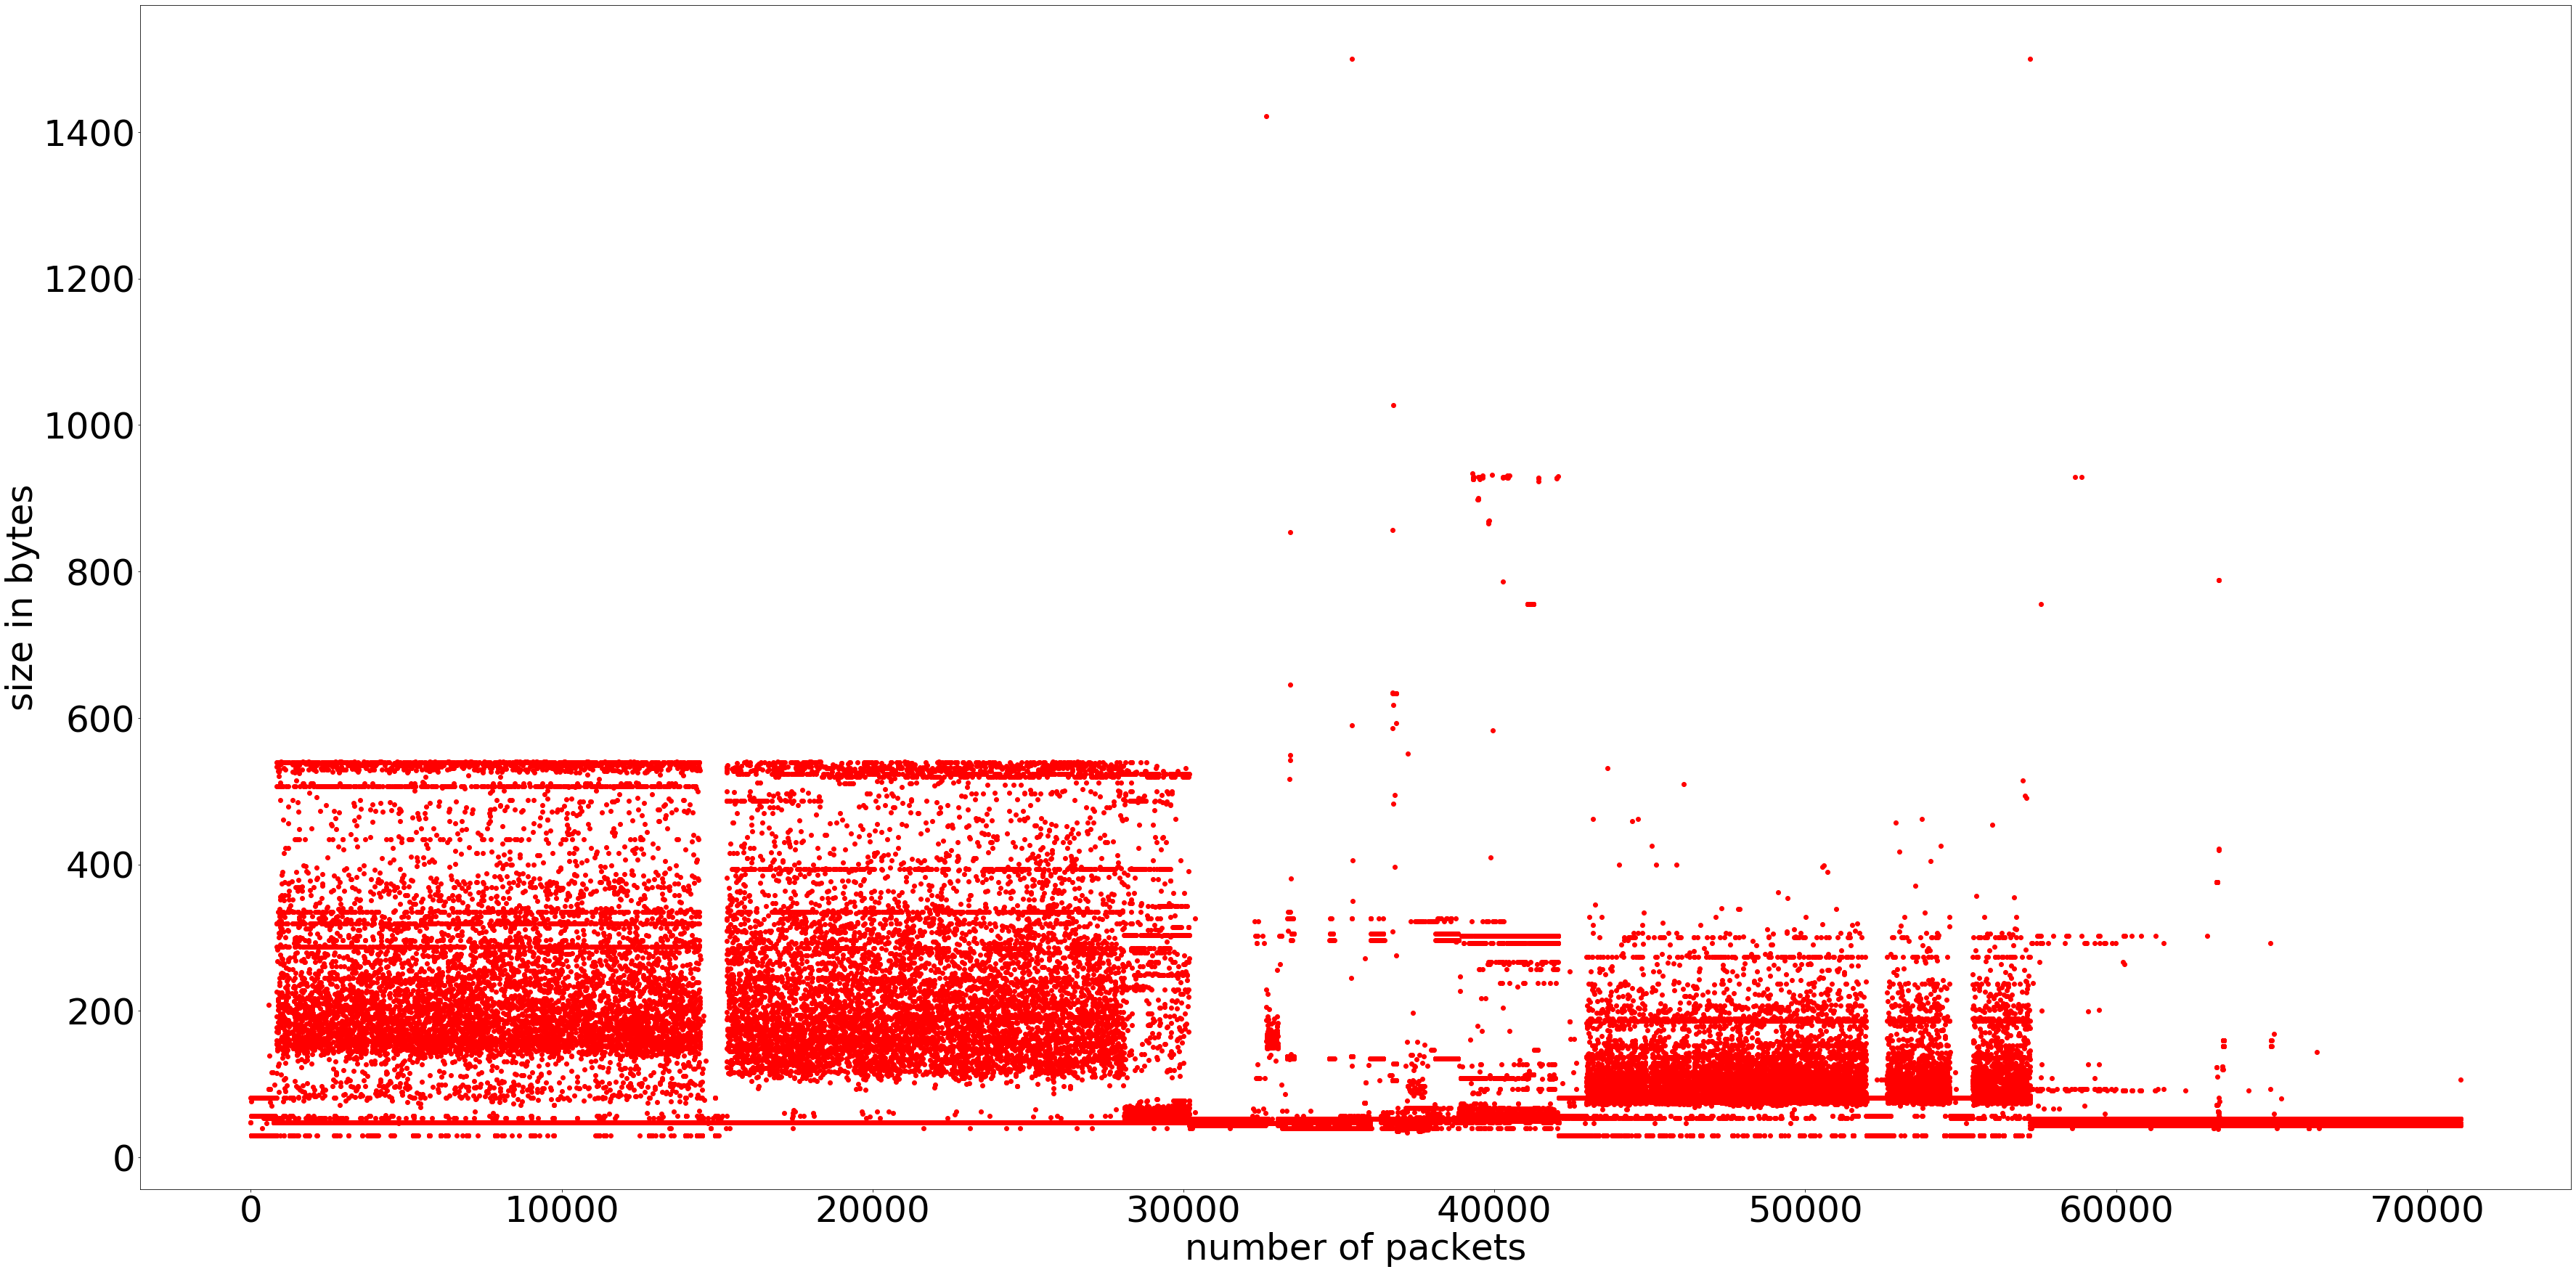

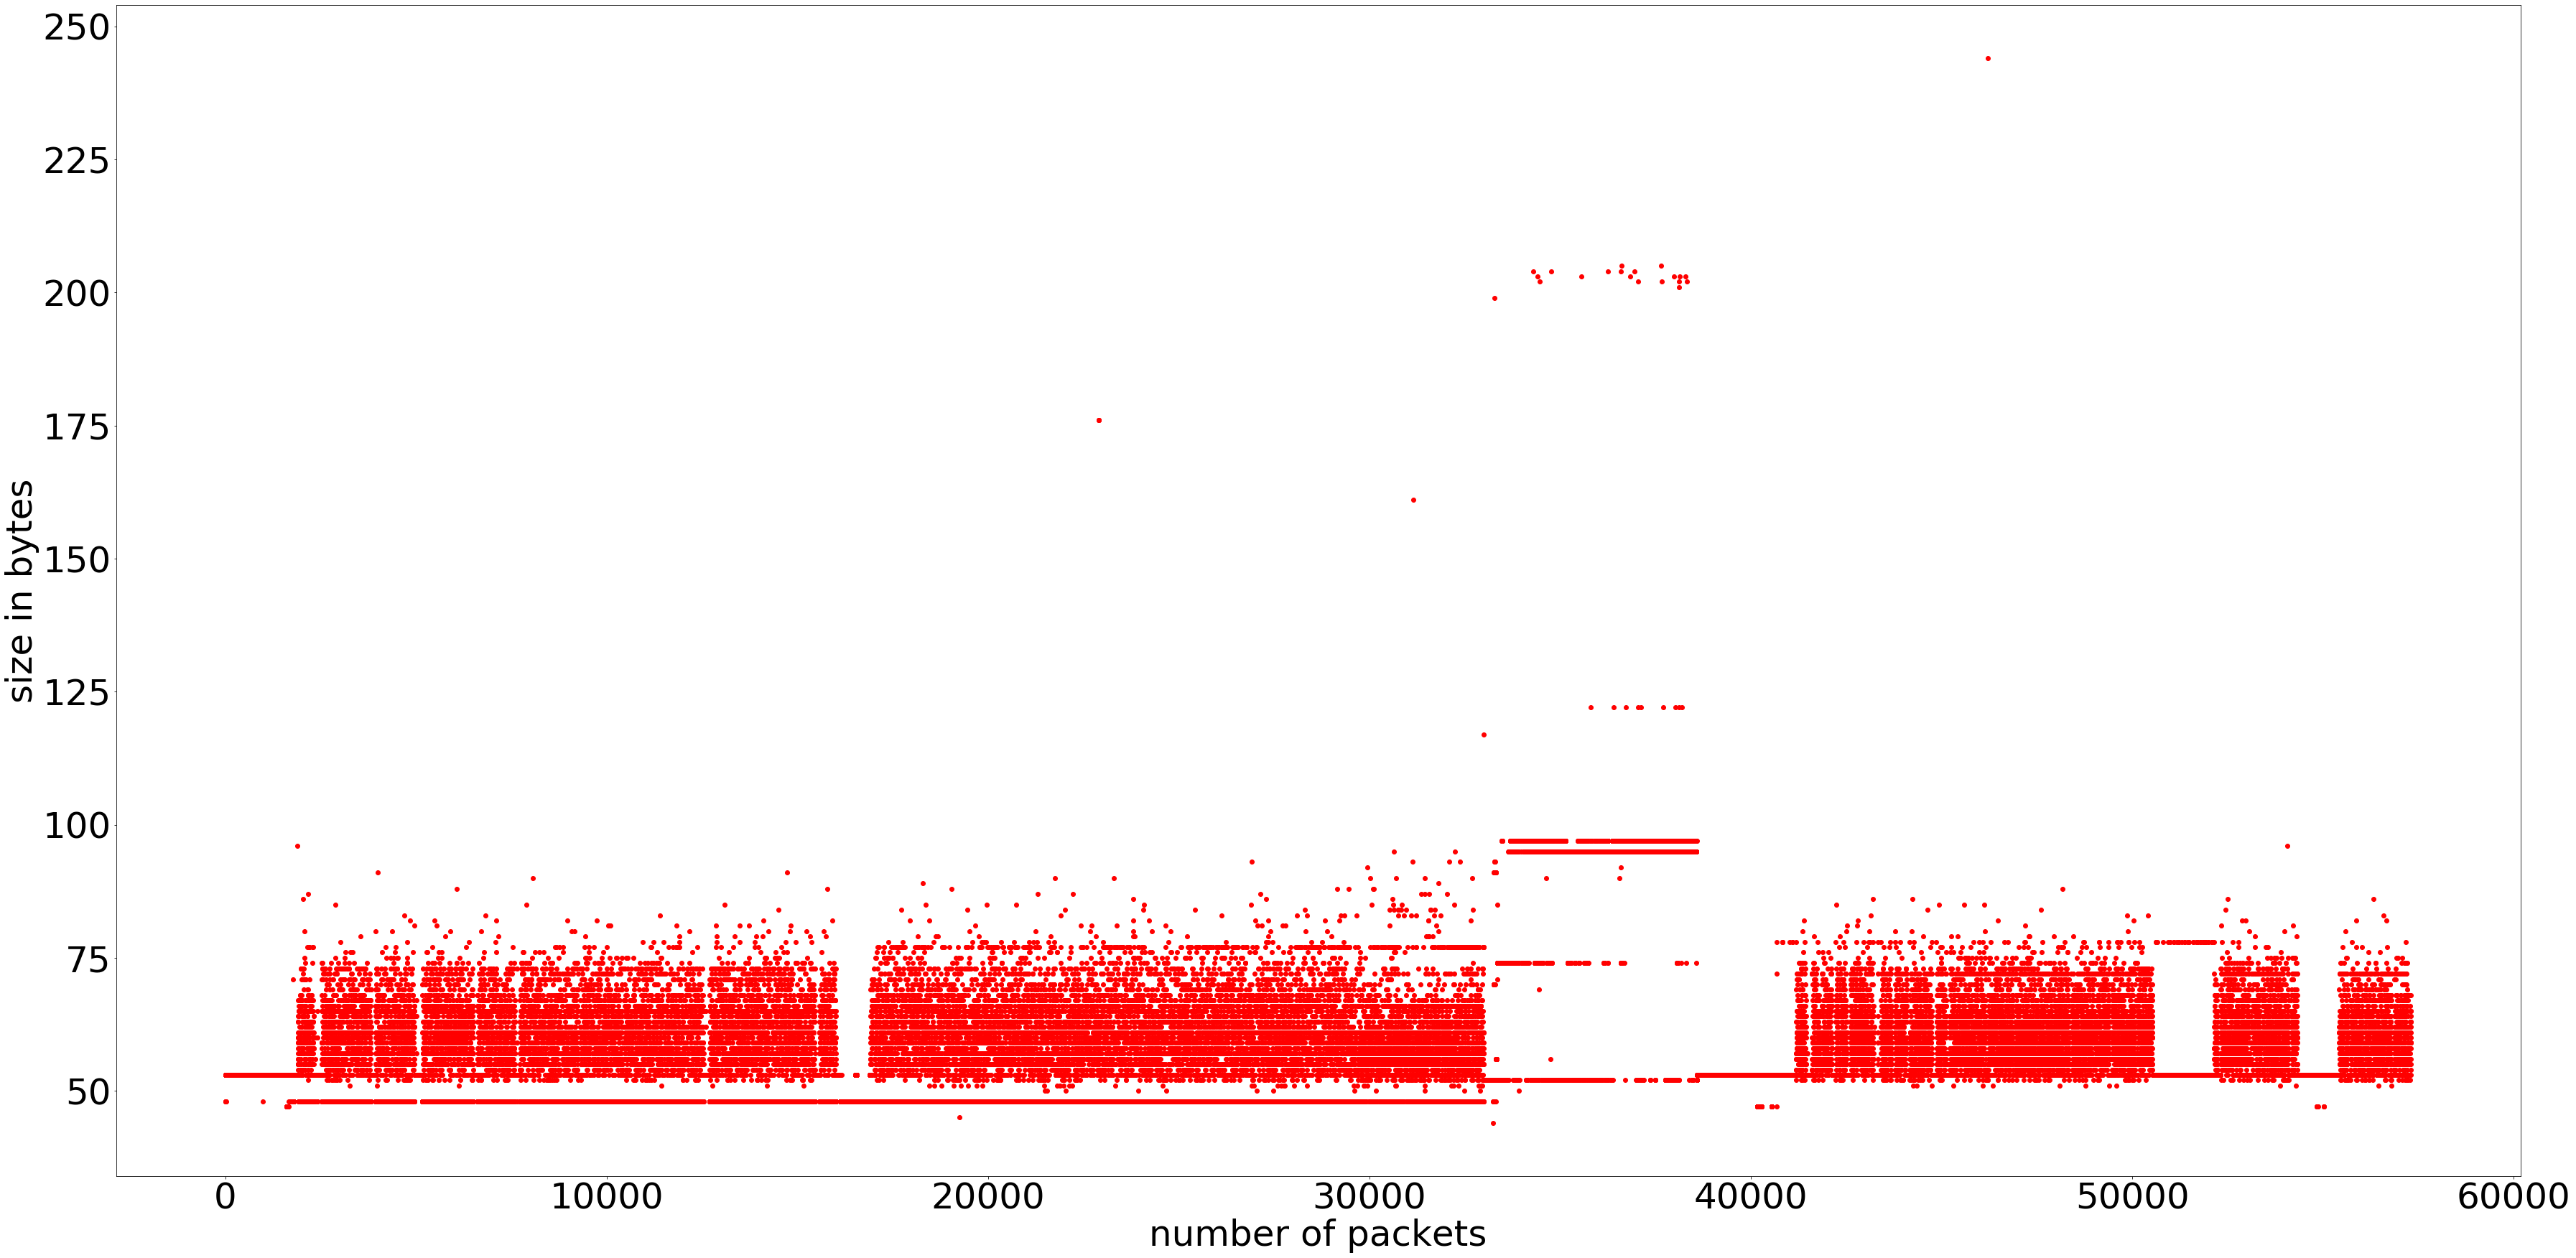

In [37]:
plotlist("malpacketlen",malpacketlen,"number of packets","size in bytes")
plotlist("nonmalpacketlen",nonmalpacketlen,"number of packets","size in bytes")

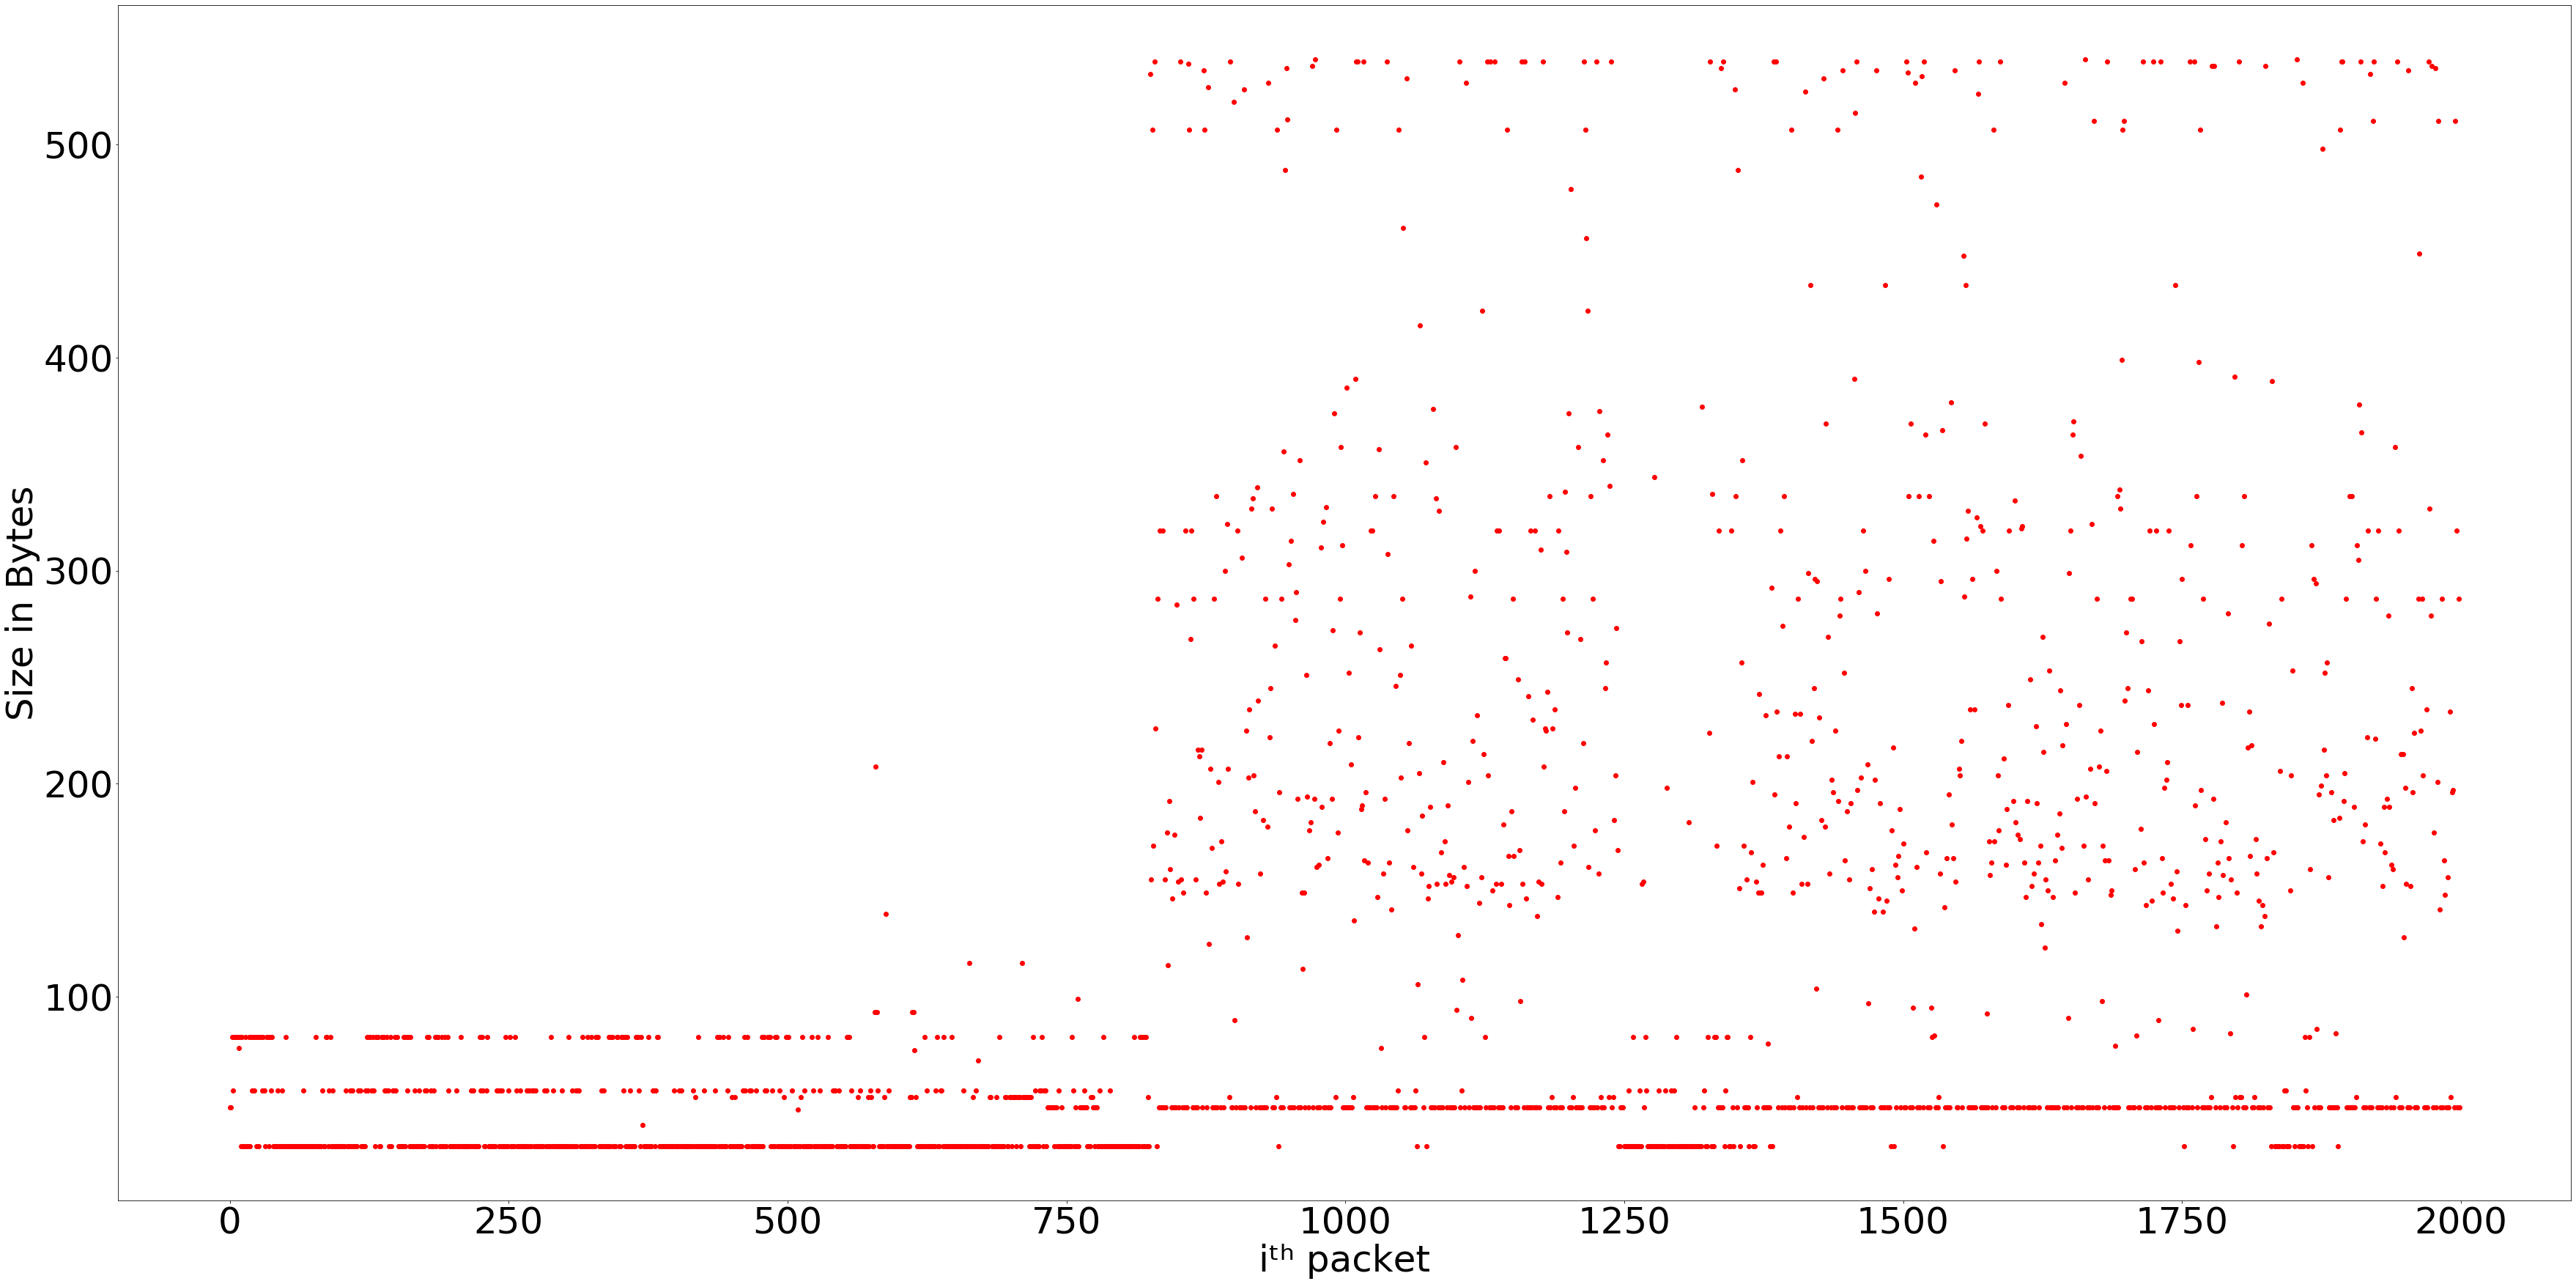

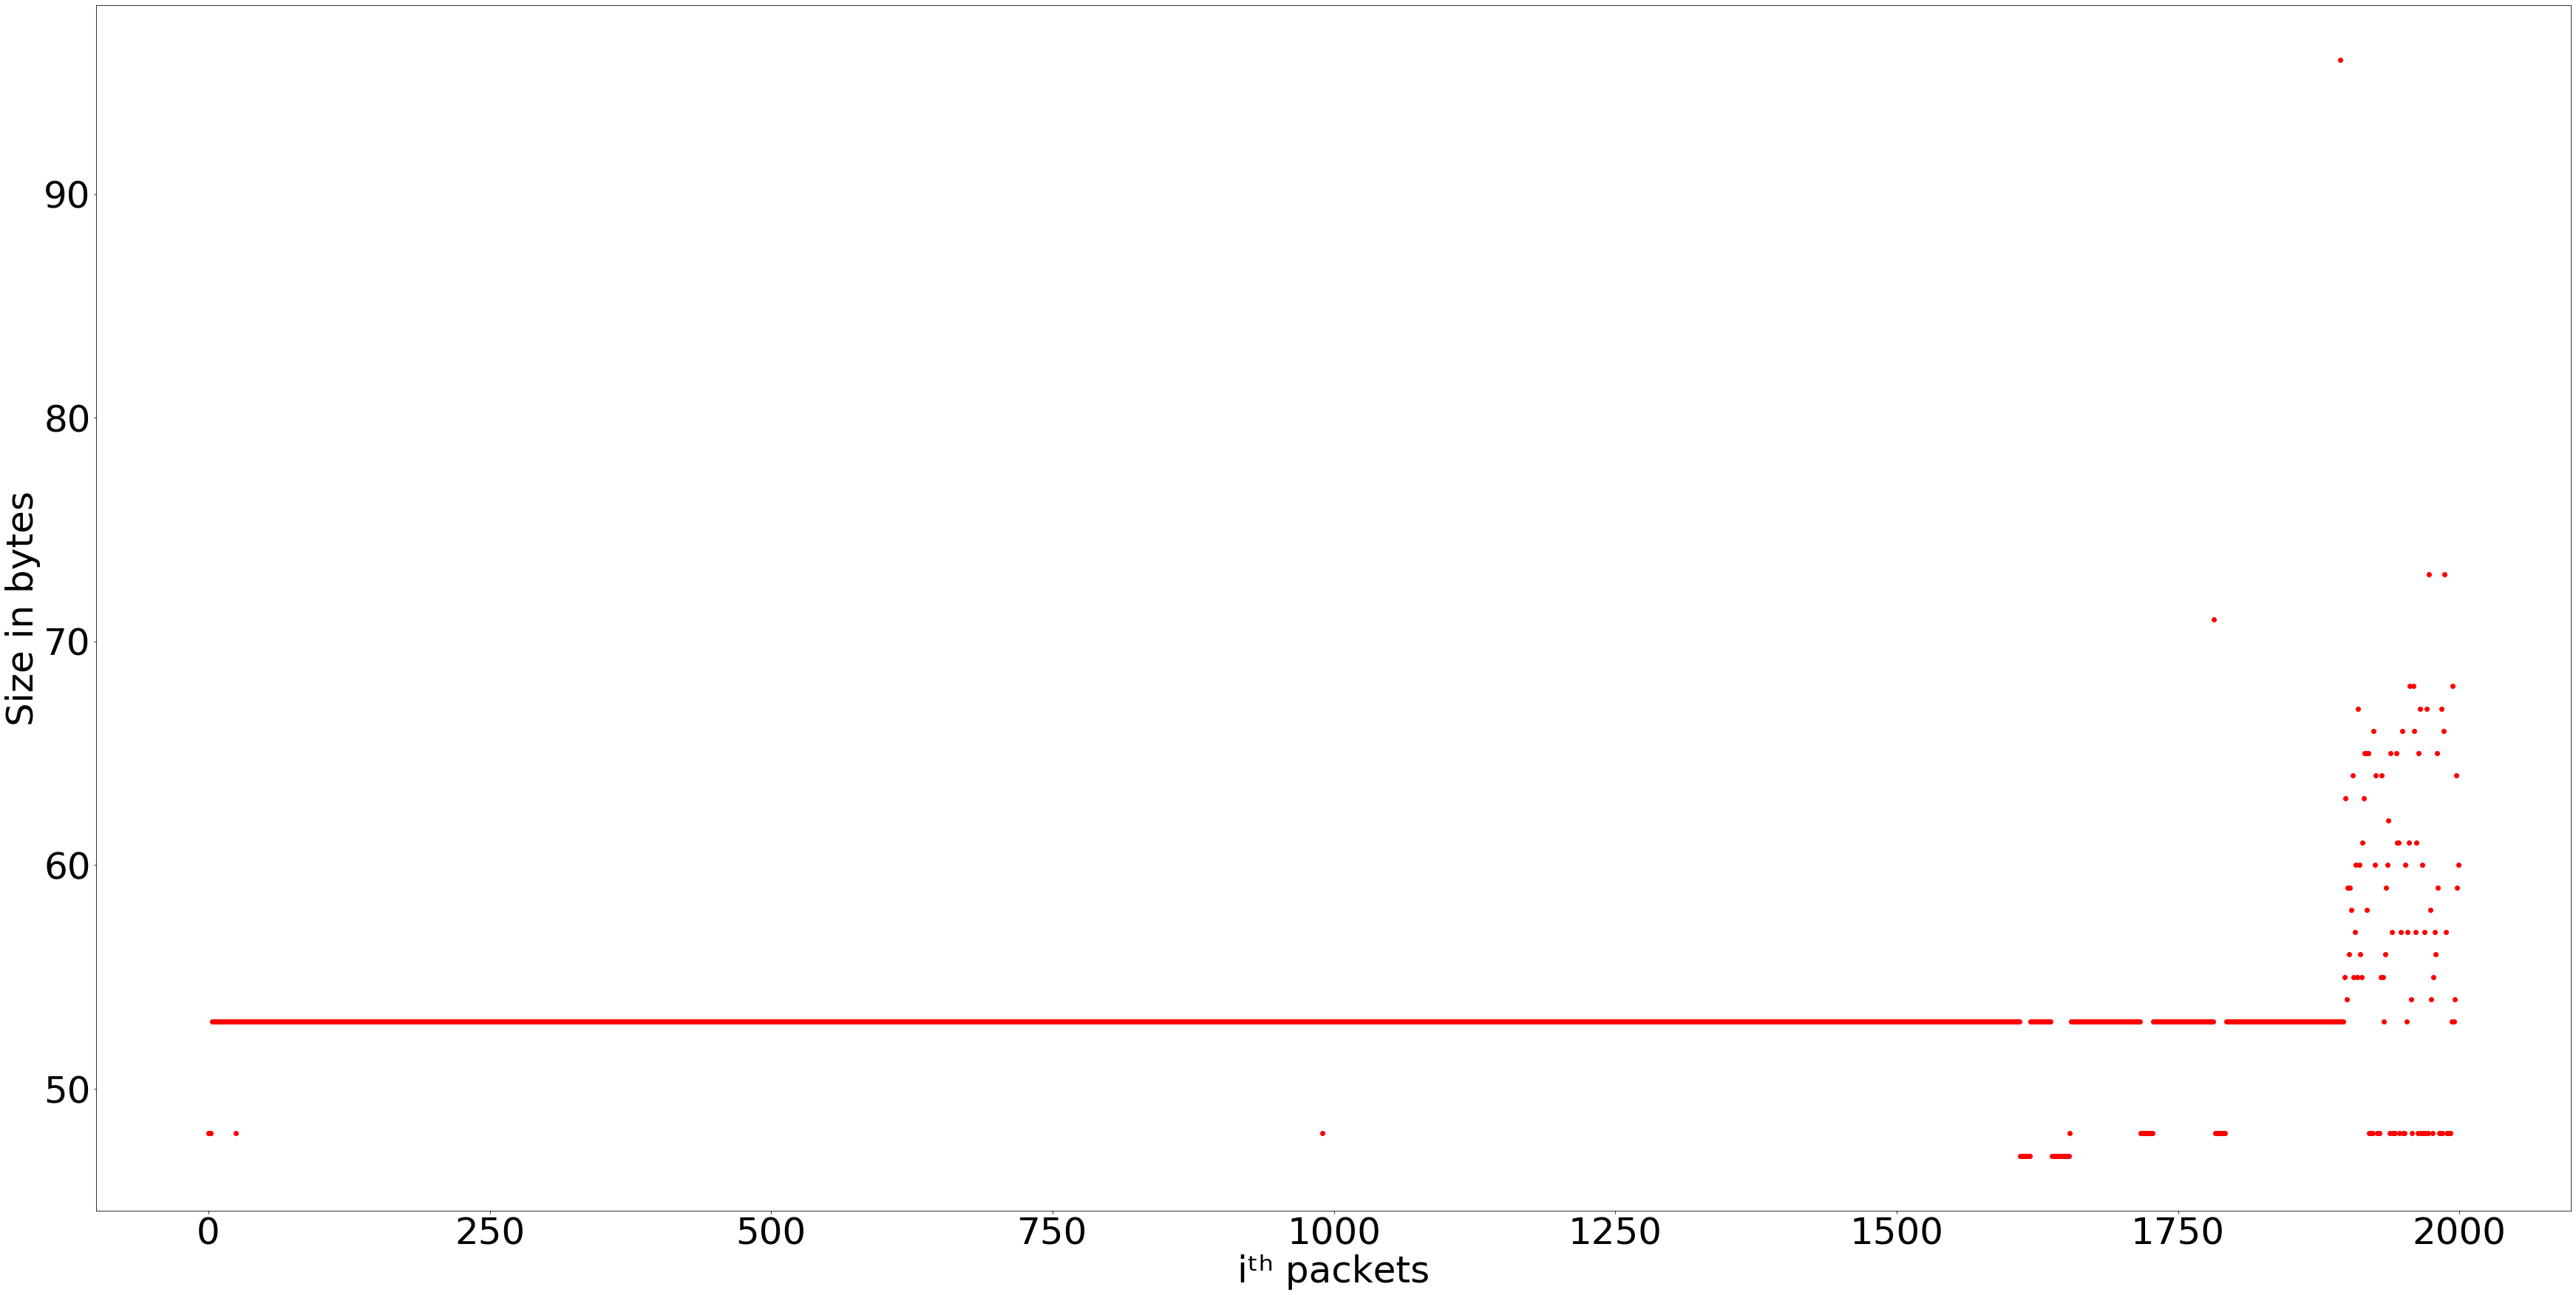

In [36]:
plotlist("malpacketlen",malpacketlen[:2000],"iᵗʰ packet","Size in Bytes")
plotlist("nonmalpacketlen",nonmalpacketlen[:2000],"iᵗʰ packets","Size in bytes")

In [41]:
#plottig bin size vs frequency for mal and non mal
malflowpacketsize5sec=[]
nonmalflowpacketsize5sec=[]
for key in flow.keys():
    starttime=flow[key][0][0]
    size=0
    for packet in flow[key]:
        if packet[0]>starttime+1:
            break
        size+=packet[1]
    if findlabel(key[0],flow[key][0][2]):
        malflowpacketsize5sec.append(size)
    else:
        nonmalflowpacketsize5sec.append(size)

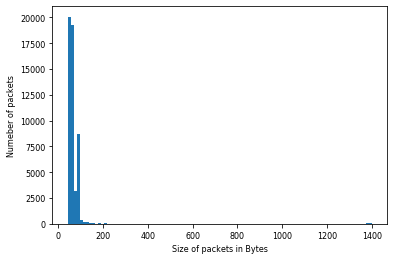

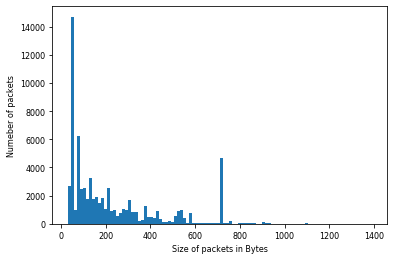

In [50]:
plt.rcParams.update({'font.size': 8})
malflowpacketsize5sec=[k for k in malflowpacketsize5sec if k<1400]
nonmalflowpacketsize5sec=[k for k in nonmalflowpacketsize5sec if k<1400]
import matplotlib.pyplot as plt
plt.hist(malflowpacketsize5sec,bins = 100)
plt.xlabel("Size of packets in Bytes")
plt.ylabel("Numeber of packets")
plt.savefig("malflowpacketsize5sec")
plt.show()
plt.hist(nonmalflowpacketsize5sec,bins = 100)
plt.xlabel("Size of packets in Bytes")
plt.ylabel("Numeber of packets")
plt.savefig("nonmalflowpacketsize5sec")
plt.show()

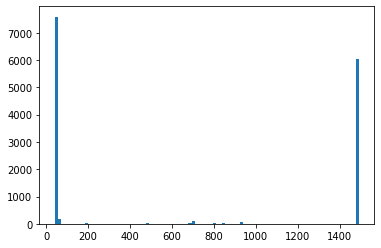

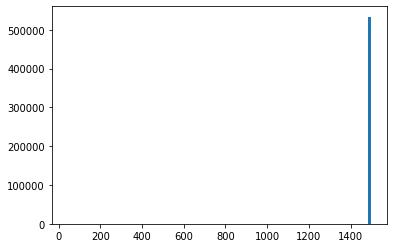

In [72]:
#packet sizes
malpacketssize=[packet[1] for packet in flow[('172.16.2.12', '90.14.88.143', 1712, 49645, 6)]]
plt.hist(malpacketssize,bins = 100)
plt.show()
malpacketssize=[packet[1] for packet in flow[('195.50.87.130','172.16.2.2',  80,1097, 6)]]
plt.hist(malpacketssize,bins = 100)
plt.show()

In [77]:
malpacketsizes={}
nonmalpacketsizes={}
for i, j in df.iterrows():
    if findlabel(j.src,j.macsrc)==1:
        if j.src in malpacketsizes.keys():
            malpacketsizes[j.src].append(j.len)
        else:
            malpacketsizes[j.src]=[j.len]
    elif findlabel(j.dst,j.macdst)==1:
        if j.dst in malpacketsizes.keys():
            malpacketsizes[j.dst].append(j.len)
        else:
            malpacketsizes[j.dst]=[j.len]
    else:
        if j.src in nonmalpacketsizes.keys():
            nonmalpacketsizes[j.src].append(j.len)
        else:
            nonmalpacketsizes[j.src]=[j.len]

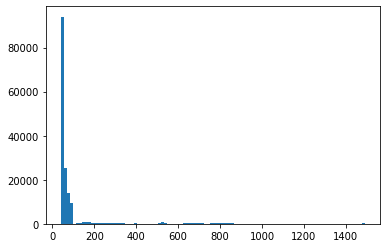

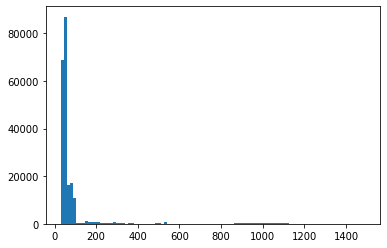

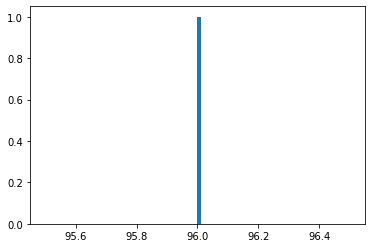

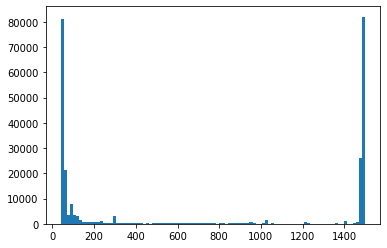

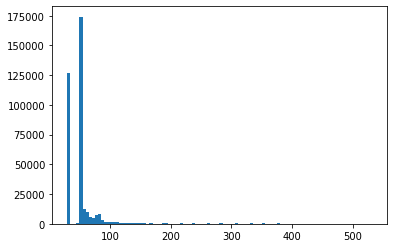

In [81]:
for ip in malpacketsizes.keys():
    plt.hist(malpacketsizes[ip],bins = 100)
    plt.show()

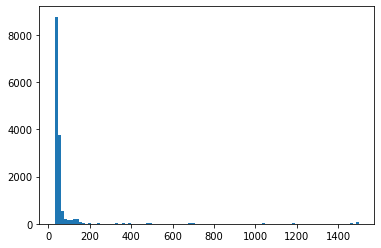

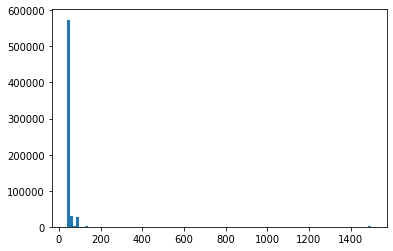

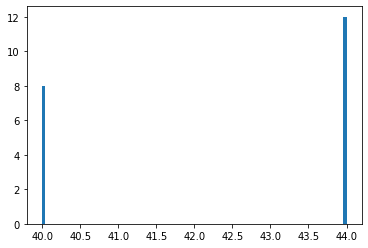

In [85]:
i=0
for ip in nonmalpacketsizes.keys():
    i+=1
    if i%4==0:
        break
    plt.hist(nonmalpacketsizes[ip],bins = 100)
    plt.show()